In [197]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import random

In [198]:
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [199]:
train = pd.read_csv(r'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\data\train.csv')
test = pd.read_csv(r'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\data\test.csv')

In [200]:
print(train.describe())
train.head()

        sentiment
count  981.000000
mean     3.136595
std      0.786166
min      1.000000
25%      3.000000
50%      3.000000
75%      3.000000
max      5.000000


sentiment                                               text
0          5  @manjulamartin @Kirk_Gleason Except trains are...
1          5                    I want a Google driverless car.
2          5  @Oatmeal @google driverless @TeslaMotors ? Ooo...
3          5  SO MUCH AWESOME! Amazing video for GoogleÌ¢‰âÂ...
4          5  @google is making driverless cars which is awe...

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='Sentiment', ylabel='Count'>

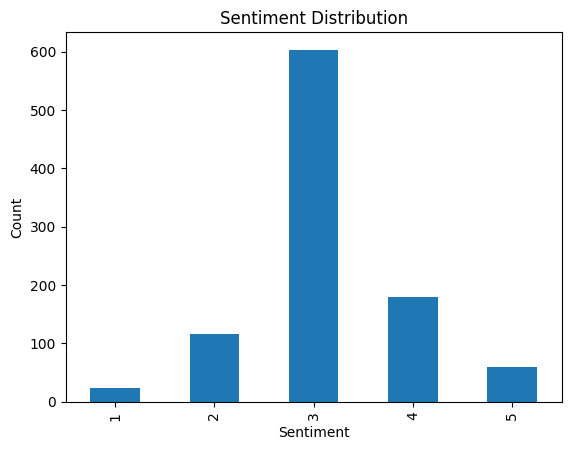

In [201]:
grouped_count = train.groupby(train['sentiment']).count()

grouped_count.plot(kind='bar', ylabel='Count', xlabel='Sentiment', title='Sentiment Distribution', legend=False)

In [202]:
print(603/len(train))

0.6146788990825688


In [203]:
X_train = train.text
y_train = train.sentiment

In [204]:
y_train

0      5
1      5
2      5
3      5
4      5
      ..
976    1
977    1
978    1
979    1
980    1
Name: sentiment, Length: 981, dtype: int64

## Synthetic Data

In [205]:
# Synthetic Data Creation
import nltk
from nltk.corpus import wordnet

np.random.seed(2023)

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def synonym_replacement(sentence):
    words = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(words)

    new_words = []
    for word, tag in pos_tags:
        synsets = wordnet.synsets(word, pos=wordnet_tag(tag))
        if synsets:
            synonyms = [lemma.name() for synset in synsets for lemma in synset.lemmas()]
            synonym = np.random.choice(synonyms) if synonyms else word
            new_words.append(synonym)
        else:
            new_words.append(word)
    return ' '.join(new_words)

def wordnet_tag(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

for itr, row in enumerate(X_train):
    print(row)
    print(synonym_replacement(row))
    break
# Add synonym replaced sentences to X_train and update y_train
X_train_synth = []
y_train_synth = []

for itr, row in enumerate(X_train):
    X_train_synth.append(row)
    # Add synthetic row
    X_train_synth.append(synonym_replacement(row))
    # append the true y-value twice. Once for the real row, and once for the same synth row
    y_train_synth.append(y_train[itr])
    y_train_synth.append(y_train[itr])

@manjulamartin @Kirk_Gleason Except trains are very capital intensive and have limited mobility. Driverless cars are the best of both worlds
@ manjulamartin @ Kirk_Gleason take_out gearing equal really majuscule intensive and birth bound mobility . Driverless railcar be the good of both world


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\connor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\connor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\connor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\connor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [206]:
print(X_train[0:10])

0    @manjulamartin @Kirk_Gleason Except trains are...
1                      I want a Google driverless car.
2    @Oatmeal @google driverless @TeslaMotors ? Ooo...
3    SO MUCH AWESOME! Amazing video for GoogleÌ¢‰âÂ...
4    @google is making driverless cars which is awe...
5    You could call a driverless car and tell the c...
6    Ì¢‰âÂÒ@Marketplace: Google's driverless cars,...
7    Driverless taxis in NYC would probably be an a...
8    This whole @google driverless car prototype th...
9    Google's New Driverless Car Has No Brake Pedal...
Name: text, dtype: object


In [207]:
print(pd.DataFrame(X_train_synth)[0:20])

                                                    0
0   @manjulamartin @Kirk_Gleason Except trains are...
1   @ manjulamartin @ Kirk_Gleason except train em...
2                     I want a Google driverless car.
3   iodine want angstrom Google driverless cable_c...
4   @Oatmeal @google driverless @TeslaMotors ? Ooo...
5   @ burgoo @ Google driverless @ TeslaMotors ? O...
6   SO MUCH AWESOME! Amazing video for GoogleÌ¢‰âÂ...
7   indeed much AWESOME ! Amazing picture for Goog...
8   @google is making driverless cars which is awe...
9   @ Google live give driverless railroad_car whi...
10  You could call a driverless car and tell the c...
11  You could ring deoxyadenosine_monophosphate dr...
12  Ì¢‰âÂÒ@Marketplace: Google's driverless cars,...
13  Ì¢‰âÂÒ @ market : Google 's driverless car , ...
14  Driverless taxis in NYC would probably be an a...
15  Driverless taxis Hoosier_State NYC would belik...
16  This whole @google driverless car prototype th...
17  This whole @ Google driv

## Shuffle and split into train/valid

Test set is on Kaggle and only takes id and labels

In [208]:
torch.tensor(y_train_synth).unique()

tensor([1, 2, 3, 4, 5])

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X_train_synth, y_train_synth, shuffle=True, test_size=0.1, random_state=42)

In [210]:
pd.DataFrame(y_test).describe()

0
count  197.000000
mean     3.172589
std      0.749598
min      1.000000
25%      3.000000
50%      3.000000
75%      4.000000
max      5.000000

In [211]:
# to_categorical has to take values 0-n not 1-n
y_train = [x-1 for x in y_train]
y_test = [x-1 for x in y_test]

In [212]:
# Convert categories to one-hot encoding
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

In [213]:
pd.DataFrame(y_test).describe()

0           1           2           3           4
count  197.000000  197.000000  197.000000  197.000000  197.000000
mean     0.015228    0.106599    0.624365    0.197970    0.055838
std      0.122772    0.309389    0.485520    0.399484    0.230193
min      0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000    0.000000    0.000000
50%      0.000000    0.000000    1.000000    0.000000    0.000000
75%      0.000000    0.000000    1.000000    0.000000    0.000000
max      1.000000    1.000000    1.000000    1.000000    1.000000

## Bag of Words feature_extractor

In [214]:
X_train_gram_vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_gram_vectorizer.fit(X_train)
X_train_gram_vectorizer = X_train_gram_vectorizer.transform(X_train).toarray()
X_train_bag_of_words = torch.tensor(X_train_gram_vectorizer)

X_test_gram_vectorizer = CountVectorizer(ngram_range=(1, 2))
X_test_gram_vectorizer.fit(X_test)
X_test_gram_vectorizer = X_test_gram_vectorizer.transform(X_train).toarray()
X_test_bag_of_words = torch.tensor(X_test_gram_vectorizer)

In [215]:
X_train_bag_of_words.unique()

tensor([0, 1, 2, 3, 5])

## Tokenize

In [216]:
# Preprocess text
# Create tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(X_train)

# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

# sequence encode
encoded_train = tokenizer.texts_to_sequences(X_train)

# pad sequences
# max_length will be a tunable hyperparameter
max_length = 200
X_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')

# Preprocess test set
# sequence encode
encoded_test = tokenizer.texts_to_sequences(X_test)

# pad sequences
X_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

In [217]:
X_train = torch.tensor(X_train, dtype=torch.int).to(device)
X_test = torch.tensor(X_test, dtype=torch.int).to(device)

y_train = torch.tensor(y_train, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

## Pretrained Embeddings

In [218]:
# Load pretrained glove twitter embeddings
import gensim

# Keep commented out since this load takes a while. Save it to disk for quicker use
# model = gensim.models.KeyedVectors.load_word2vec_format(r'C:\Users\connor\PycharmProjects\rice\comp_647\assignment_2\pretrained_embeddings\glove.twitter.27B.200d_wv.txt')
# model.save(r'C:\Users\connor\PycharmProjects\rice\comp_647\assignment_2\pretrained_embeddings\glove.twitter.27B.200d_usable_weights')
model = gensim.models.KeyedVectors.load(
    r'C:\Users\connor\PycharmProjects\rice\comp_647\assignment_2\pretrained_embeddings\glove.twitter.27B.200d_usable_weights')
weights = torch.FloatTensor(model.vectors)
embedding = nn.Embedding.from_pretrained(weights, freeze=True)

In [219]:
# Confirm embeddings work, get embeddings for index 1
input = torch.LongTensor([1])
embedding(input)

tensor([[ 3.5132e-01,  5.6084e-04, -2.1488e-01, -4.7070e-02, -1.7777e-01,
          6.6162e-01, -7.4805e-03, -1.5963e-01, -2.2129e-01,  6.5523e-01,
          3.4600e-01, -2.2968e-01, -7.8954e-02,  2.7465e-01,  3.6018e-01,
          2.0373e-01, -4.8134e-02,  9.1749e-02, -9.3562e-02, -8.8653e-02,
         -6.1514e-01, -1.1240e-01, -2.1046e-01,  1.3129e-01,  1.1224e-01,
         -9.2995e-01, -1.8006e-01,  9.6874e-03,  9.3647e-01, -1.9493e-01,
         -1.3873e-01,  1.8719e-01, -2.2502e-02,  3.9516e-01,  3.3007e-01,
          3.6089e-01,  7.8608e-03, -2.4064e-02, -3.2890e-01, -2.8101e-01,
         -2.0223e-01,  3.0049e-01, -2.2843e-01,  6.3900e-02,  5.9025e-01,
         -1.7992e-01,  7.2733e-01,  2.8216e-02, -4.3656e-01, -6.4330e-02,
          8.7363e-02,  5.4825e-03,  3.4902e-01,  8.1738e-02,  3.5089e-01,
          5.3459e-02,  5.5370e-02,  1.0797e-01,  1.9663e-01,  6.3077e-01,
         -7.4041e-02,  1.3848e-01,  2.4849e-01, -1.0183e-01,  4.2992e-01,
         -4.1886e-01,  1.0814e-02, -4.

## Twitter-roBERTa-base

In [220]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
twitter_roberta = AutoModelForSequenceClassification.from_pretrained(MODEL)



Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [221]:
twitter_roberta

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [222]:
# You must batch twitter_roberta or it will run out of memory
class TWITTERROBERTA(nn.Module):
    def __init__(self, pretrained_model=twitter_roberta, requires_grad=False, classes=5):
        super().__init__()
        self.twitter_roberta = pretrained_model
        
        self.twitter_roberta.transform_input=False
        self.twitter_roberta.classifier.out_proj = nn.Linear(768, classes)
    
        # freeze the last layer if false
        if not requires_grad:
            self._freeze_param()
    
    def _freeze_param(self):
        for k,v in self.named_parameters():
            if k.startswith("out_proj"):
                v.requires_grad = True
                                   
    def forward(self, x):
        return self.twitter_roberta(x).logits

In [223]:
# Need to create dataloader object for twitter-roBERTa since it is too big. 
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [224]:
## confirm dataloader is functioning properly
# for train, label in train_dataloader:
#     print(train)
#     print()
#     print(label)
#     break

## Transformer Encoder

In [225]:
# not working correctly when batched
class TransformerEncoder(nn.Module):
    def __init__(self, heads, num_linear_layers, num_classes=5):
        super(TransformerEncoder, self).__init__()
        # create embeddings
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=max_length)
        # Initialize the encoder 
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=max_length, nhead=heads), num_layers=num_linear_layers)
        # Define the fully connected layer
        self.linear = nn.Linear(max_length, num_classes)

    def forward(self, x):
        # Pass the input through the transformer encoder 
        x = self.encoder(x)
        x = x.mean(dim=1) 
        return self.linear(x)

## CNN

In [226]:
class CNN(nn.Module):
    def __init__(self, cnn_num_classes=5, dropout_rate=0, batch_norm=False, num_linear_layers=3, num_neurons=16, num_cnn_layers=3, num_filters=32, activation_function=nn.ReLU(), pretrained_embedding=False):
        super().__init__()
        
        # feature extraction
        if pretrained_embedding:
            self.embedding = embedding
        else:
            self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=max_length)
        self.cnn = nn.Conv1d(in_channels=max_length, out_channels=num_filters, kernel_size=3, padding='same')
        self.flatten = nn.Flatten()
        # first and last linear layer and other one use layers
        self.linear = nn.Linear(in_features=max_length*num_filters, out_features=num_neurons)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.output = nn.Linear(in_features=num_neurons, out_features=cnn_num_classes)
        self.activation_function = activation_function
        self.batch_normalization = nn.BatchNorm1d(num_features=num_neurons)
        
        # layer lists
        self.dropout_list = nn.ModuleList([nn.Dropout(dropout_rate) for dummy in range(num_linear_layers-1)])
        self.batch_normalization_list = nn.ModuleList([nn.BatchNorm1d(num_features=num_neurons) for dummy in range(num_linear_layers-1)]) #batch norm doesn't make sense for unbatched data which is what I have
        self.hidden_layers_list = nn.ModuleList([nn.Linear(num_neurons, num_neurons) for dummy in range(num_linear_layers-1)])
        self.hidden_cnn_layers_list = nn.ModuleList([nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, padding='same') for dummy in range(num_cnn_layers-1)])
        
        # parameters used in forward function
        self.num_linear_layers = num_linear_layers
        self.num_cnn_layers = num_cnn_layers
        self.batch_norm = batch_norm
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.cnn(x)
        for layer in range(self.num_cnn_layers-1):
            x = self.hidden_cnn_layers_list[layer](x)
        x = self.flatten(x)
        if self.batch_norm:
            x = self.dropout(self.activation_function(self.batch_normalization(self.linear(x))))
        else:
            x = self.dropout(self.activation_function(self.linear(x)))
        for layer in range(self.num_linear_layers-1):
            if self.batch_norm:
                x = self.dropout_list[layer](self.activation_function(self.batch_normalization_list[layer](self.hidden_layers_list[layer](x))))
            else:
                x = self.dropout_list[layer](self.activation_function(self.hidden_layers_list[layer](x)))
        x = self.output(x)
        return x
        
        

In [227]:
def train_twitter_roberta(model, criterion, optimizer, num_epochs, model_name, train_dataloader=train_dataloader, test_dataloader=test_dataloader, early_stopping=True, device=device):
    epoch_train_loss_list = []
    epoch_train_accuracy_list = []
    epoch_valid_loss_list = []
    epoch_valid_accuracy_list = []
    early_stopping_counter = 0
    best_loss = np.inf
    
    for epoch in range(num_epochs):
        for train_x_data, train_y_data in train_dataloader:
            train_x_data.to(device)
            train_y_data.to(device)
            
            model.train()
            optimizer.zero_grad()
            outputs = model(train_x_data)
            loss_train = criterion(outputs, train_y_data)
            
            # Take softmax of the output -> get the argmax to convert it to a single number -> one hot encode to get it to the same format as the label. 
            softmax_outputs = torch.nn.functional.one_hot(torch.argmax(nn.Softmax(dim=0)(outputs), dim=1)).to(torch.float)
            total_right = 0
            
            # update since now using batch sizes that aren't equal to the full data length
            for row in range(len(train_y_data)):
                # need to use .equal since torchmetrics.accuracy will evaluate each value in each row. Ex.) pred = [0,0,1,0,0,0], actual = [1,0,0,0,0,0] as 66% correct. Expected behavior is this would be 0%
                if torch.equal(softmax_outputs[row], train_y_data[row]):
                    total_right += 1       
            epoch_accuracy_train = total_right / len(train_y_data)
        
            epoch_train_loss_list.append(loss_train.item())
            epoch_train_accuracy_list.append(epoch_accuracy_train)
        
            loss_train.backward()
            optimizer.step()
    
        model.eval()
        with torch.no_grad():
            for valid_x_data, valid_y_data in test_dataloader:
                valid_x_data.to(device)
                valid_y_data.to(device)
                
                outputs = model(valid_x_data)
                loss_valid = criterion(outputs, valid_y_data)
                best_accuracy = -np.inf
                
                softmax_outputs = torch.nn.functional.one_hot(torch.argmax(nn.Softmax(dim=0)(outputs), dim=1)).to(torch.float)
                total_right = 0
                for row in range(len(valid_y_data)):
                    # need to use .equal since torchmetrics.accuracy will evaluate each value in each row. Ex.) pred = [0,0,1,0,0,0], actual = [1,0,0,0,0,0] as 66% correct. Expected behavior is this would be 0%
                    if torch.equal(softmax_outputs[row], valid_y_data[row]):
                        total_right += 1       
                epoch_accuracy_valid = total_right / len(valid_y_data)
        
                epoch_valid_loss_list.append(loss_valid.item())
                epoch_valid_accuracy_list.append(epoch_accuracy_valid)

        if loss_valid.item() < best_loss:
            early_stopping_counter = 0
            best_loss = loss_valid.item()
            torch.save(model.state_dict(), fr'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\model_weights\model_weights\{model_name}')

        # if epoch_accuracy_valid >= best_accuracy:
        #     best_accuracy = epoch_accuracy_valid
        #     torch.save(model.state_dict(), fr'C:\Users\connor\PycharmProjects\comp_647_final\model_weights\{model_name}_accuracy')

        # Stop training if after early_stopping_patience epochs, validation loss does not go down
        print('Epoch:', epoch, 'Best Valid Loss:', best_loss, 'Current Valid loss:', loss_valid.item(), 'Current Train loss:', loss_train.item(), 'Stop Counter:', early_stopping_counter)
        early_stopping_counter += 1
        if early_stopping and early_stopping_counter >= 10:
            print("Early Stopping Triggered")
            break
        
    return epoch_train_loss_list, epoch_valid_loss_list, epoch_train_accuracy_list, epoch_valid_accuracy_list

In [228]:
def train_model(model, criterion, optimizer, train_x_data, train_y_data, valid_x_data, valid_y_data, num_epochs, model_name, early_stopping=True, device=device):
    epoch_train_loss_list = []
    epoch_train_accuracy_list = []
    epoch_valid_loss_list = []
    epoch_valid_accuracy_list = []
    early_stopping_counter = 0
    best_loss = np.inf
    
    train_x_data.to(device)
    train_y_data.to(device)
    valid_x_data.to(device)
    valid_y_data.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_x_data)
        loss_train = criterion(outputs, train_y_data)
        
        # Take softmax of the output -> get the argmax to convert it to a single number -> one hot encode to get it to the same format as the label. 
        softmax_outputs = torch.nn.functional.one_hot(torch.argmax(nn.Softmax(dim=0)(outputs), dim=1)).to(torch.float)
        total_right = 0
        for row in range(len(train_y_data)):
            # need to use .equal since torchmetrics.accuracy will evaluate each value in each row. Ex.) pred = [0,0,1,0,0,0], actual = [1,0,0,0,0,0] as 66% correct. Expected behavior is this would be 0%
            if torch.equal(softmax_outputs[row], train_y_data[row]):
                total_right += 1       
        epoch_accuracy_train = total_right / len(train_y_data)
        
        epoch_train_loss_list.append(loss_train.item())
        epoch_train_accuracy_list.append(epoch_accuracy_train)
        
        loss_train.backward()
        optimizer.step()
    
        model.eval()
        with torch.no_grad():
            outputs = model(valid_x_data)
            loss_valid = criterion(outputs, valid_y_data)
            best_accuracy = -np.inf
            
            softmax_outputs = torch.nn.functional.one_hot(torch.argmax(nn.Softmax(dim=0)(outputs), dim=1)).to(torch.float)
            total_right = 0
            for row in range(len(valid_y_data)):
                # need to use .equal since torchmetrics.accuracy will evaluate each value in each row. Ex.) pred = [0,0,1,0,0,0], actual = [1,0,0,0,0,0] as 66% correct. Expected behavior is this would be 0%
                if torch.equal(softmax_outputs[row], valid_y_data[row]):
                    total_right += 1       
            epoch_accuracy_valid = total_right / len(valid_y_data)
    
            epoch_valid_loss_list.append(loss_valid.item())
            epoch_valid_accuracy_list.append(epoch_accuracy_valid)

        if loss_valid.item() < best_loss:
            early_stopping_counter = 0
            best_loss = loss_valid.item()
            torch.save(model.state_dict(), fr'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\model_weights\{model_name}')

        # if epoch_accuracy_valid >= best_accuracy:
        #     best_accuracy = epoch_accuracy_valid
        #     torch.save(model.state_dict(), fr'C:\Users\connor\PycharmProjects\comp_647_final\model_weights\{model_name}_accuracy')

        # Stop training if after early_stopping_patience epochs, validation loss does not go down
        print('Epoch:', epoch, 'Best Valid Loss:', best_loss, 'Current Valid loss:', loss_valid.item(), 'Current Train loss:', loss_train.item(), 'Stop Counter:', early_stopping_counter)
        early_stopping_counter += 1
        if early_stopping and early_stopping_counter >= 10:
            print("Early Stopping Triggered")
            break
        
    return epoch_train_loss_list, epoch_valid_loss_list, epoch_train_accuracy_list, epoch_valid_accuracy_list

In [229]:
def test_accuracy(model, X_test_data, y_test_data):
    # epoch_accuracy_valid = Accuracy(task="multiclass", num_classes=6).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_data)
        # Take softmax of the output -> get the argmax to convert it to a single number -> one hot encode to get it to the same format as the label. 
        softmax_outputs = torch.nn.functional.one_hot(torch.argmax(nn.Softmax(dim=0)(outputs), dim=1)).to(torch.float)
        #softmax_outputs = torch.nn.functional.one_hot(torch.argmax(nn.Softmax(dim=-1)(outputs), dim=1)).to(torch.float)
        
        total_right = 0
        for row in range(len(y_test_data)):
            # need to use .equal since torchmetrics.accuracy will evaluate each value in each row. Ex.) pred = [0,0,1,0,0,0], actual = [1,0,0,0,0,0] as 66% correct. Expected behavior is this would be 0%
            if torch.equal(softmax_outputs[row], y_test_data[row]):
                total_right += 1
                
        accuracy = total_right / len(y_test_data)

    return accuracy, softmax_outputs

In [230]:
def plot_loss_and_accuracy(train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, title):
    """
    train_loss_list: list containing the loss per epoch of the training data during training
    valid_loss_list: list containing the loss of the valid dataset using the trained dataset at the end of each epoch
    """
    fig, axes = plt.subplots(nrows=2)
    fig.suptitle(title,x=.55, y=1.75, fontsize=20)
    
    axes[0].set_title('Training and Validation Loss')    
    axes[0].plot(train_loss_list, color='b', label='Training Loss')
    axes[0].plot(valid_loss_list, color='orange', label='Validation Loss')
    axes[0].legend(['Train', 'Valid'])
    axes[0].set_xlabel('Num Epoch')
    axes[0].set_ylabel('Loss')
    
    axes[1].set_title('Training and Validation Accuracy')    
    axes[1].plot(train_accuracy_list, color='b', label='Training Accuracy')
    axes[1].plot(valid_accuracy_list, color='orange', label='Validation Accuracy')
    axes[1].legend(['Train', 'Valid'])
    axes[1].set_xlabel('Num Epoch')
    axes[1].set_ylabel('Accuracy')
    
    plt.tight_layout()
    plt.subplots_adjust(top=1.5)
    
    return fig, axes

In [231]:
def trainable_parameters_count(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

In [232]:
## Random Grid Search Func
def random_grid_search(architecture_type, lr_list, activation_function_list, neuron_num_list, batch_norm_list, dropout_rate_list, num_linear_layers, num_cnn_layers, num_epochs, early_stop_num, num_classes=5, num_combos=5, seed_value=None, pretrained_embeddings=False):
    # set seed for reproducibility
    random.seed(seed_value)
    
    best_model_loss = np.inf
    best_rand_grid_model = None
    # randomly choose combo
    for dummy in range(num_combos):
        lr = random.choice(lr_list)
        activation = random.choice(activation_function_list)
        linear_layers = random.choice(num_linear_layers_list)
        cnn_layers = random.choice(num_cnn_layers_list)
        neuron_num = random.choice(neuron_num_list)
        batch_norm_t_f = random.choice(batch_norm_list)
        dropout = random.choice(dropout_rate_list)
        network_name = str(lr) + '_' + str(activation) + '_' + str(neuron_num) + '_' + str(batch_norm_t_f) + '_' + str(dropout) + '_' + str(linear_layers) + '_' + str(cnn_layers) + '_' +str(architecture_type) + '_' +str(pretrained_embeddings)
        
        if architecture_type == 'CNN':
            grid = CNN(cnn_num_classes=num_classes, activation_function=activation, num_neurons=neuron_num, num_linear_layers=linear_layers, num_cnn_layers=cnn_layers, batch_norm=batch_norm_t_f, dropout_rate=dropout, pretrained_embedding=pretrained_embeddings)
        # REPLACE WITH SECOND MODEL TYPE
        elif architecture_type == 'Transformer':
            grid = CNN(cnn_num_classes=num_classes, activation_function=activation, num_neurons=neuron_num, num_linear_layers=linear_layers, num_cnn_layers=cnn_layers, batch_norm=batch_norm_t_f, dropout_rate=dropout)
        grid.to(device)
        loss = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(grid.parameters(), lr=lr)
        print('Network Name:', network_name, 'Trainable Parameters:', trainable_parameters_count(grid))
        train_loss, valid_loss, train_acc, valid_acc = train_model(model=grid, criterion=loss, optimizer=optimizer, train_x_data=X_train, valid_x_data=X_test, train_y_data=y_train, valid_y_data=y_test, num_epochs=num_epochs, early_stopping=False, model_name=network_name, device=device)
        
        # plot training and validation loss as well as accuracy for both
        plot_loss_and_accuracy(train_loss, valid_loss, train_acc, valid_acc, title=network_name)
        # keep track of which model had the lowest loss of all models. This model is saved as network_name in the model_weights directory
        min_valid_loss = np.inf
        for val in valid_loss:
            if val < min_valid_loss:
                min_valid_loss = val
                
        if min_valid_loss < best_model_loss:
            best_model_loss = min_valid_loss
            best_rand_grid_model = network_name
            
    return best_rand_grid_model

## Build model

In [233]:
# parameter tuning
num_classes = 5
num_epochs = 1000
early_stop_num = 100
num_linear_layers_list = [3,4,5,8]
num_cnn_layers_list = [3,4,5,8]
lr_list = [.0001, .00001, .000001, .0000001]
activation_function_list = [nn.ReLU(), nn.LeakyReLU(), nn.Softmax(dim=0)]
dropout_rate_list = [.1, .2, .5, .75]
neuron_num_list = [16, 32, 64, 128, 256, 512]
batch_norm_list = [True, False]

Network Name: 1e-06_LeakyReLU(negative_slope=0.01)_128_True_0.75_8_5_Transformer_False Trainable Parameters: 2078053
Epoch: 0 Best Valid Loss: 1.615929126739502 Current Valid loss: 1.615929126739502 Current Train loss: 2.0132462978363037 Stop Counter: 0
Epoch: 1 Best Valid Loss: 1.615929126739502 Current Valid loss: 1.618981957435608 Current Train loss: 1.9956096410751343 Stop Counter: 1
Epoch: 2 Best Valid Loss: 1.615929126739502 Current Valid loss: 1.6204272508621216 Current Train loss: 1.9668306112289429 Stop Counter: 2
Epoch: 3 Best Valid Loss: 1.615929126739502 Current Valid loss: 1.6213898658752441 Current Train loss: 1.9802861213684082 Stop Counter: 3
Epoch: 4 Best Valid Loss: 1.615929126739502 Current Valid loss: 1.622162938117981 Current Train loss: 1.9724308252334595 Stop Counter: 4
Epoch: 5 Best Valid Loss: 1.615929126739502 Current Valid loss: 1.6218518018722534 Current Train loss: 1.9393380880355835 Stop Counter: 5
Epoch: 6 Best Valid Loss: 1.615929126739502 Current Valid 

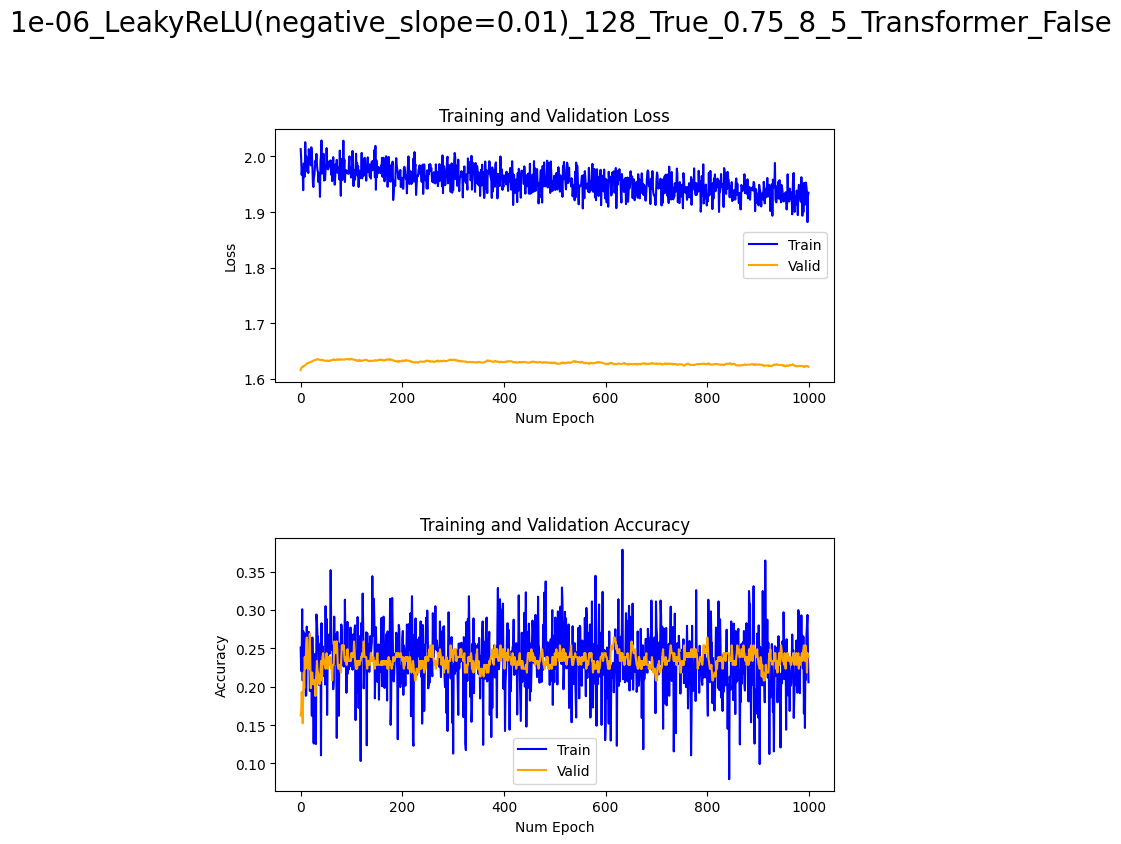

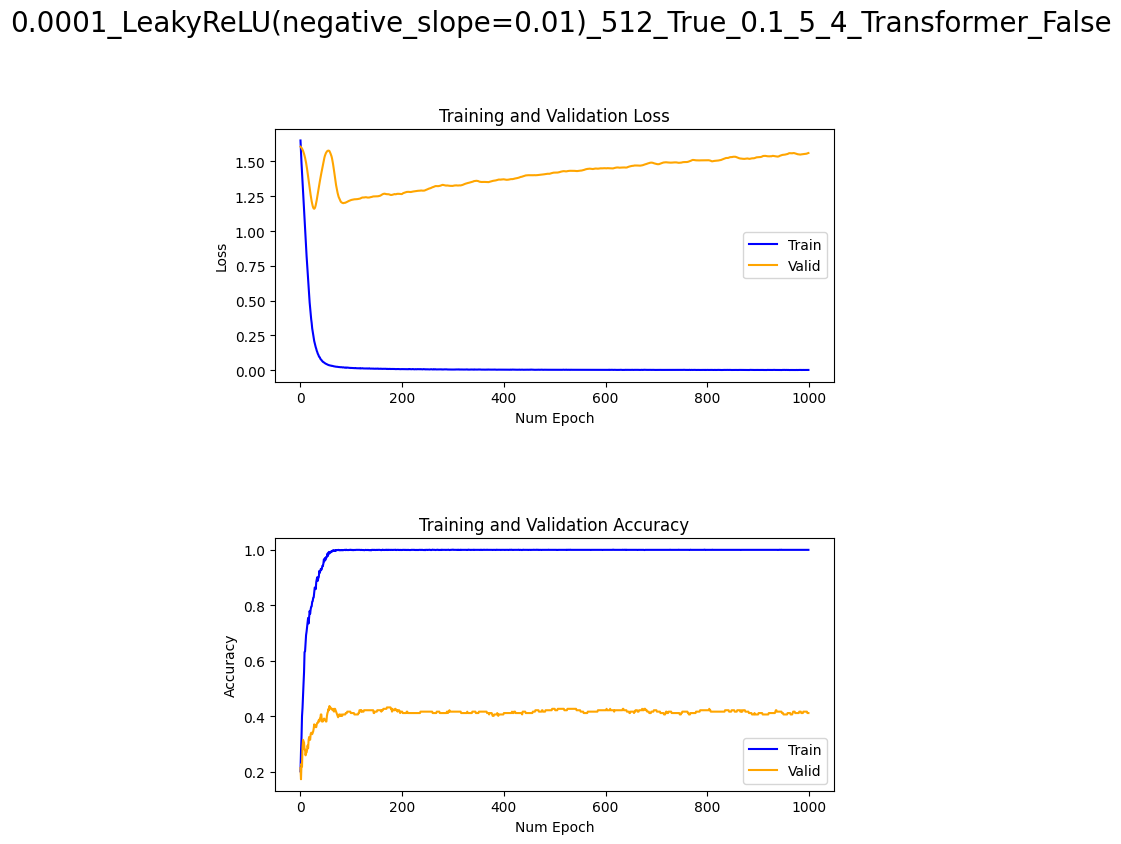

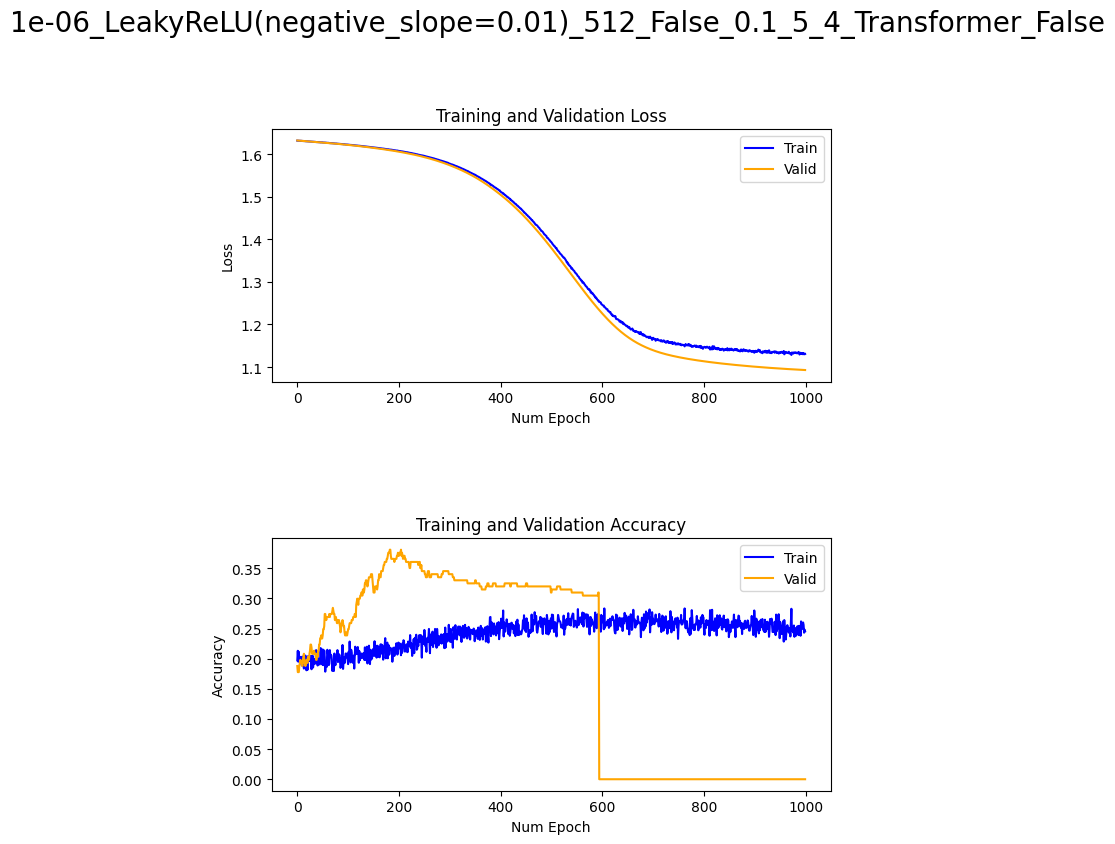

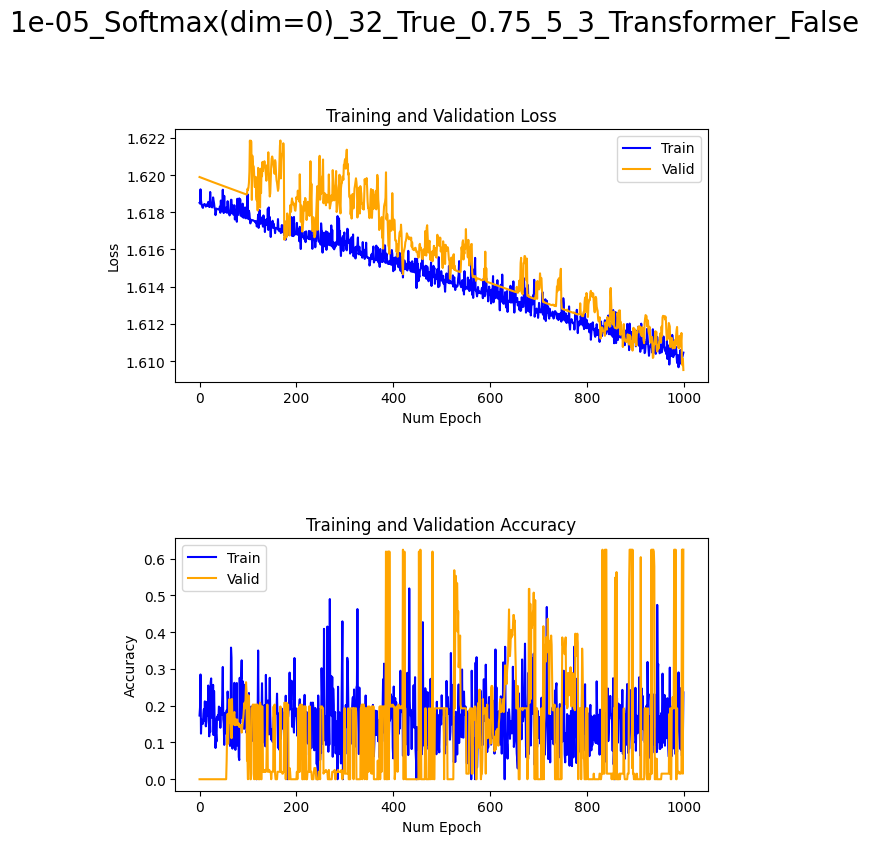

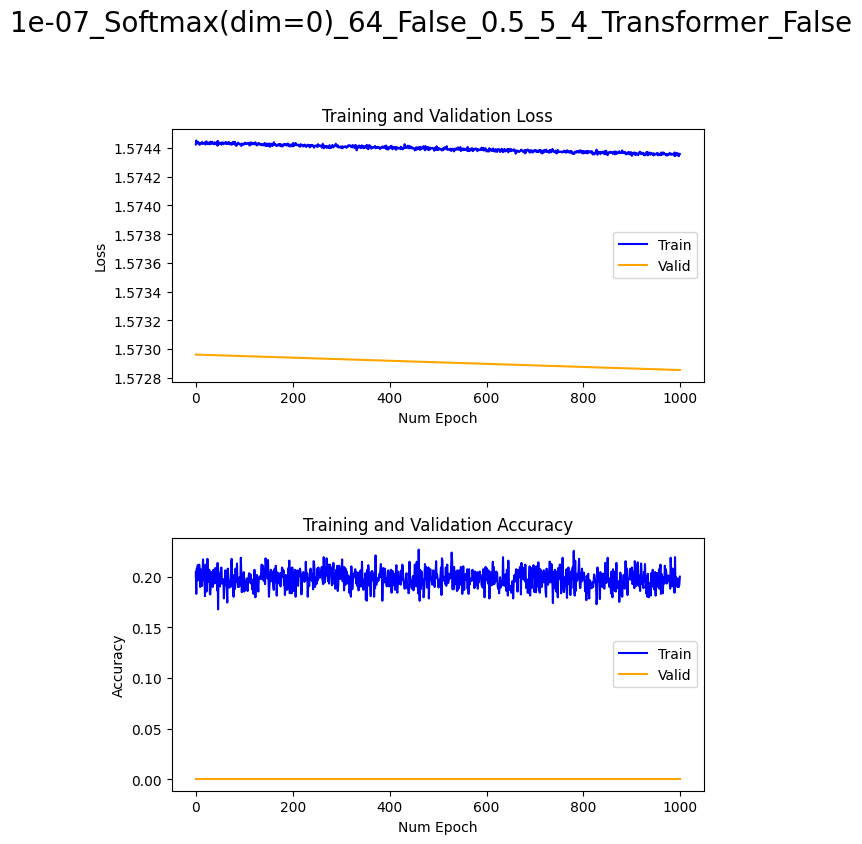

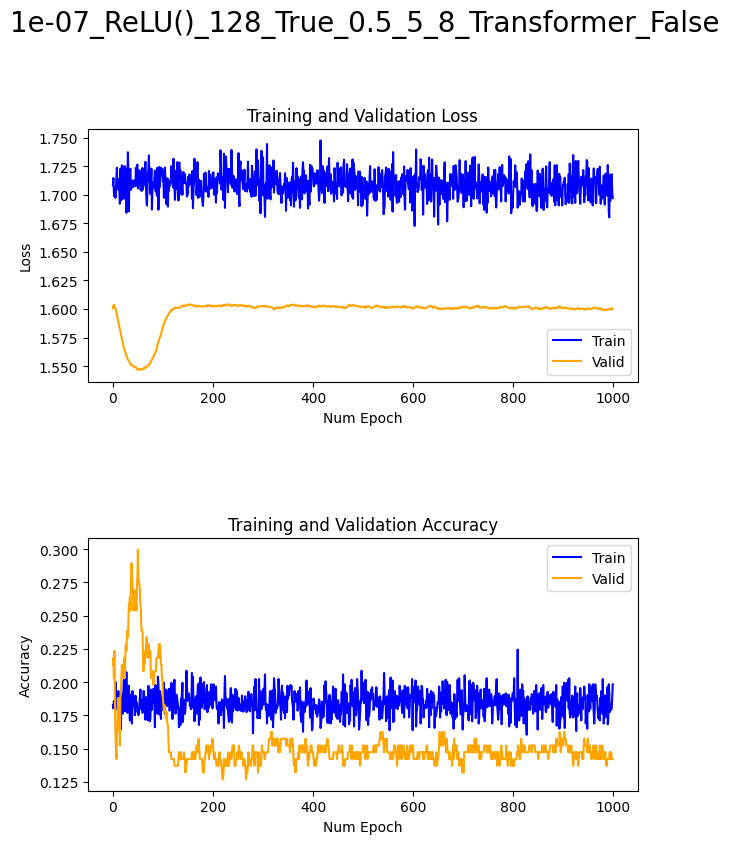

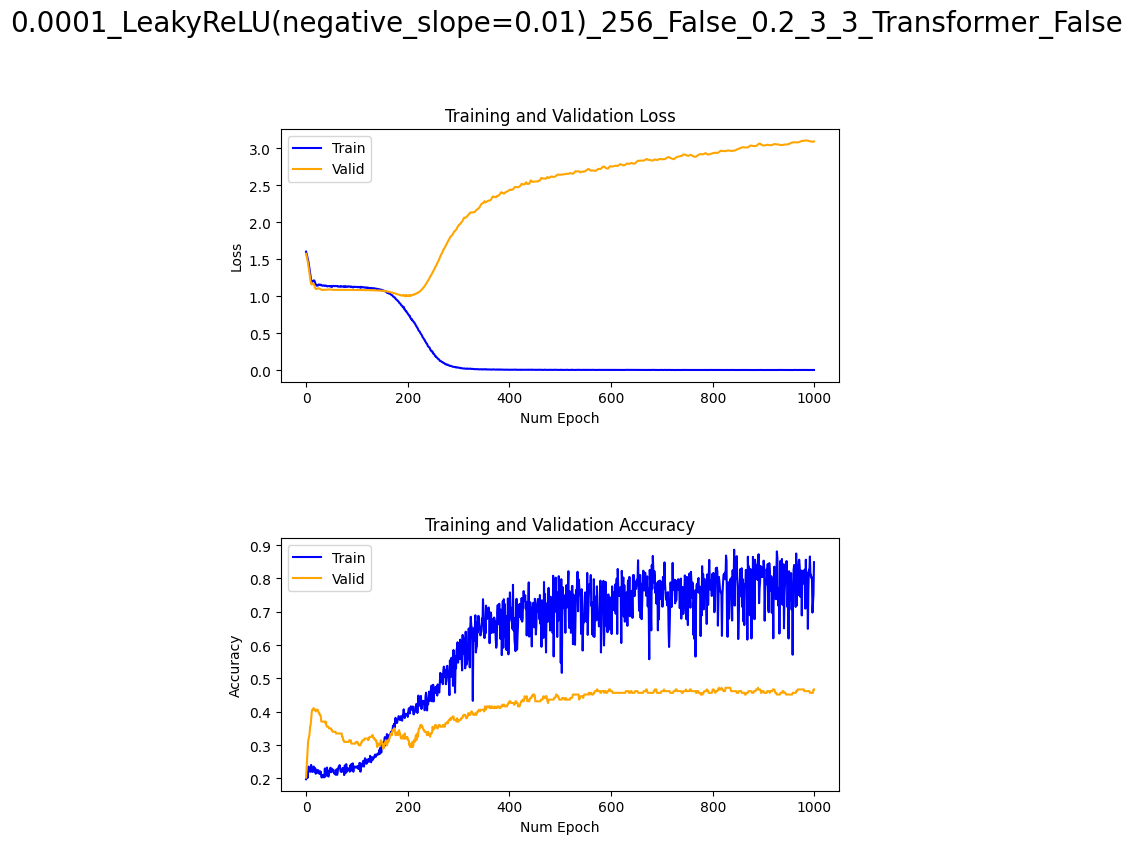

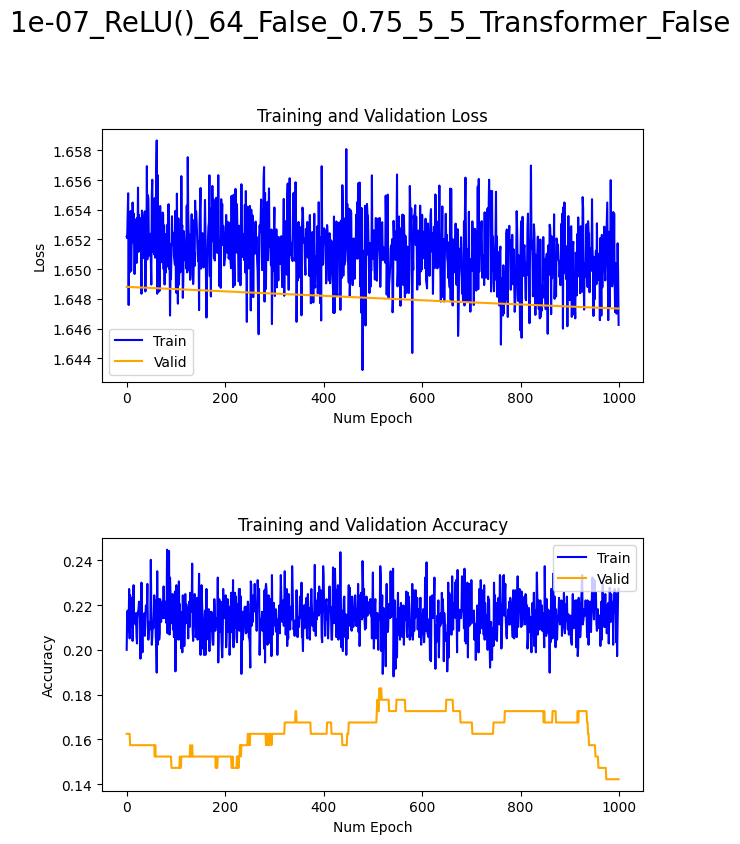

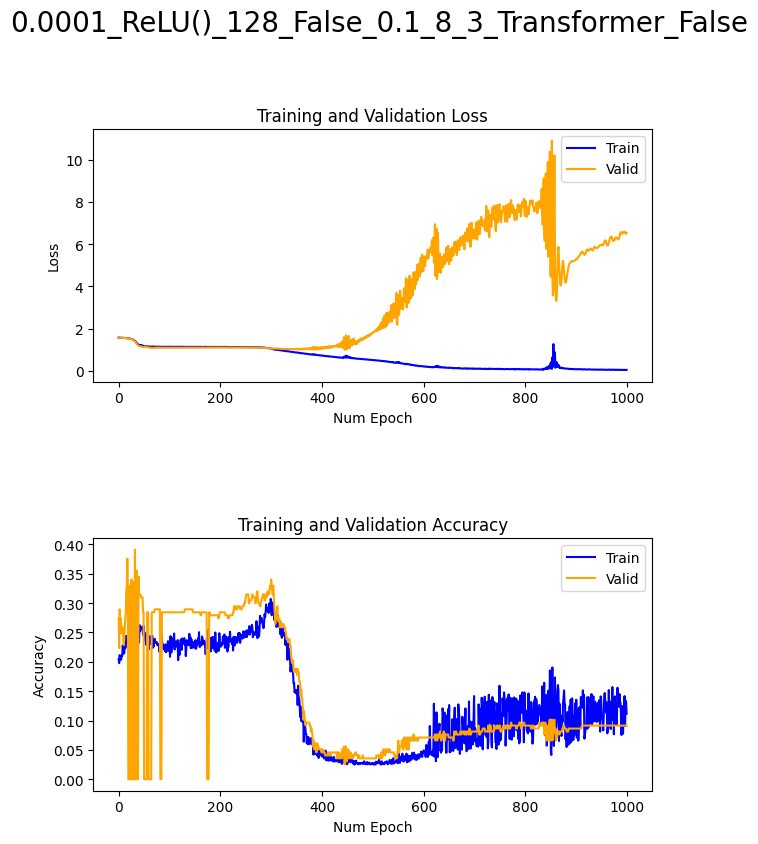

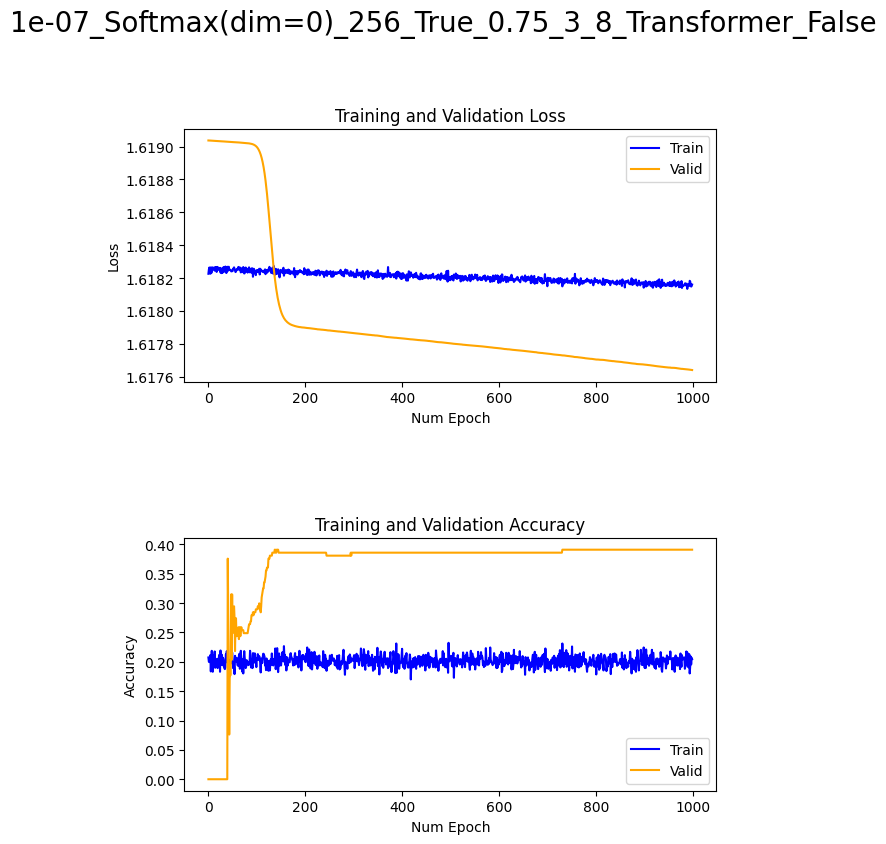

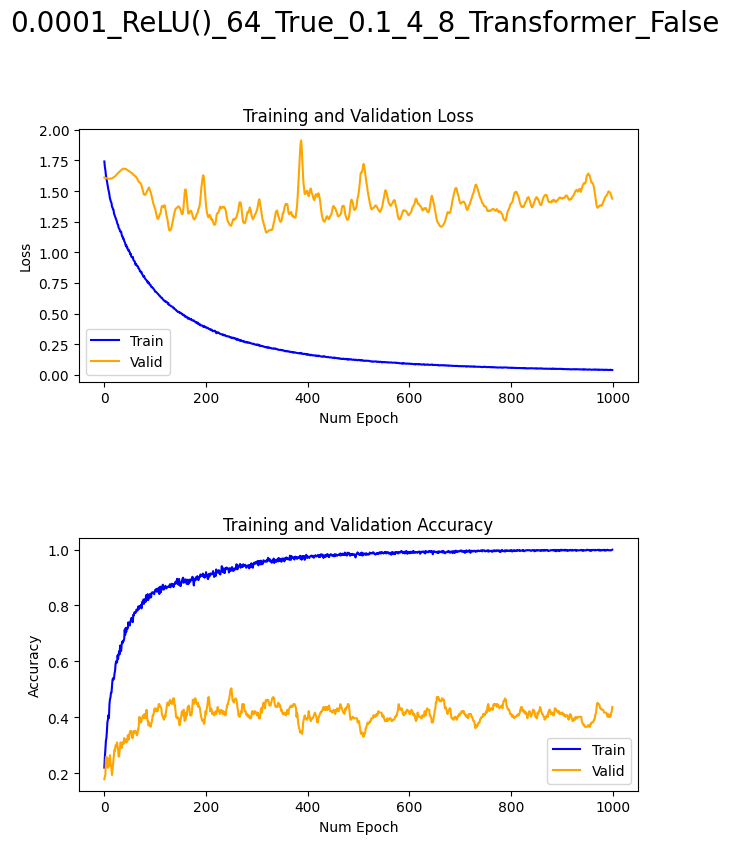

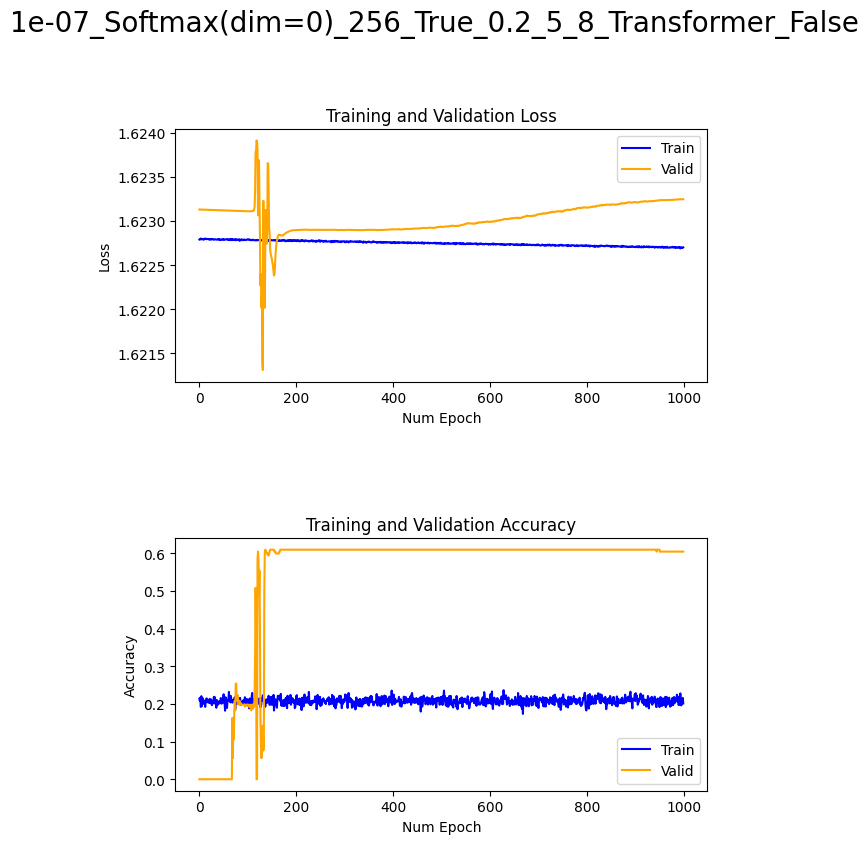

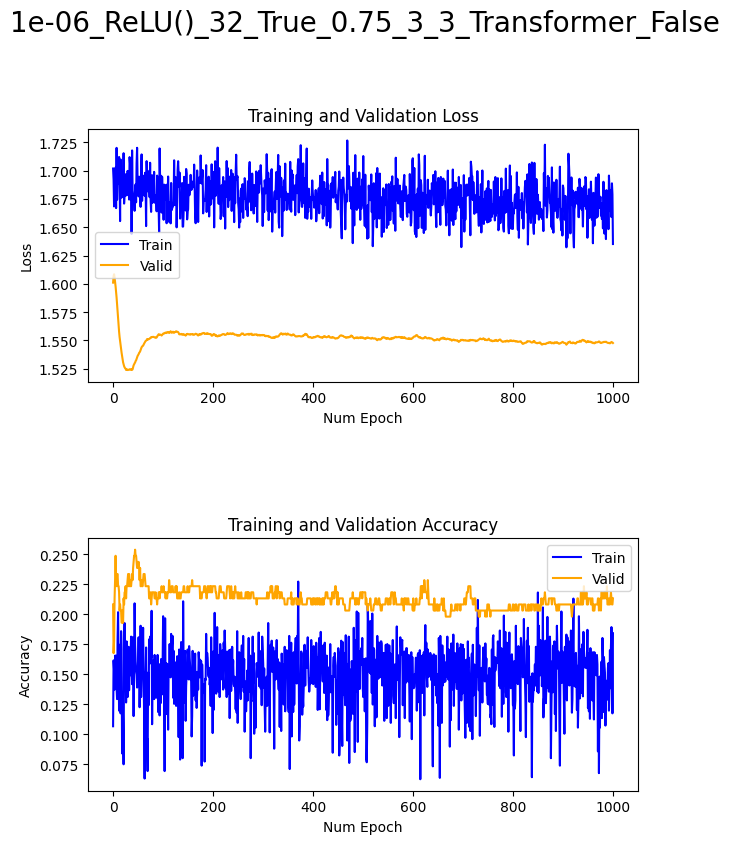

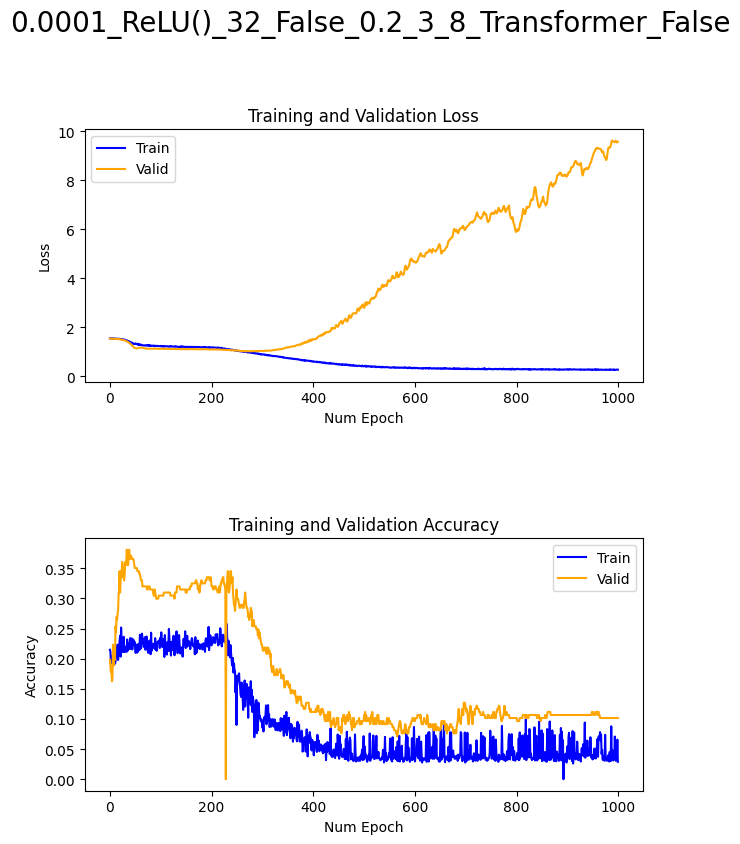

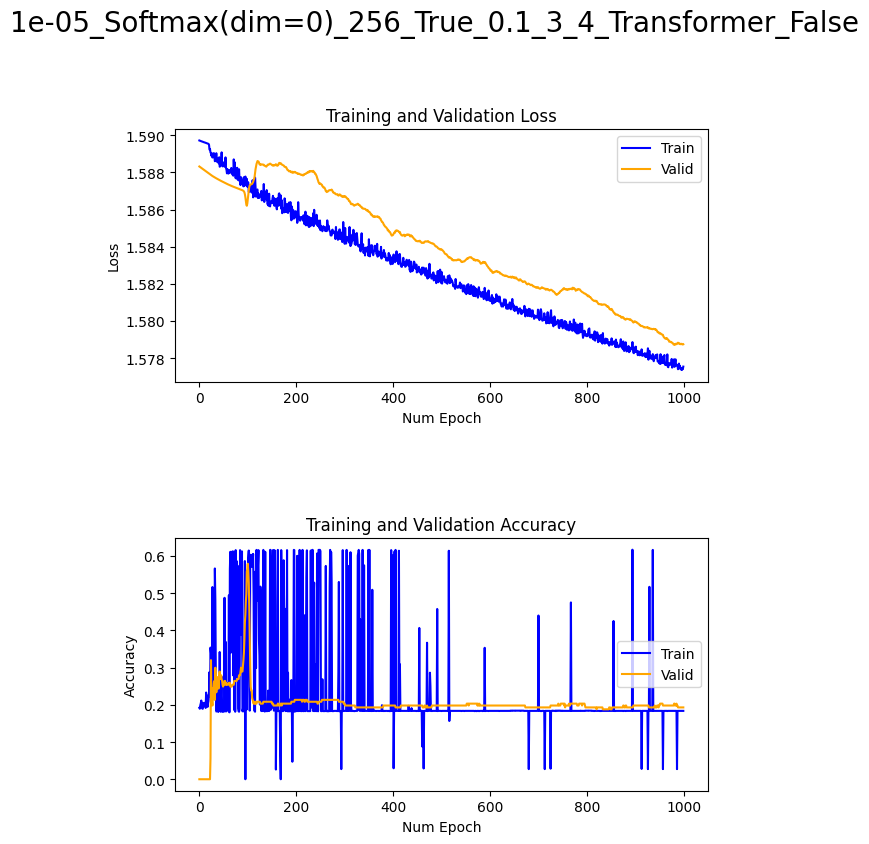

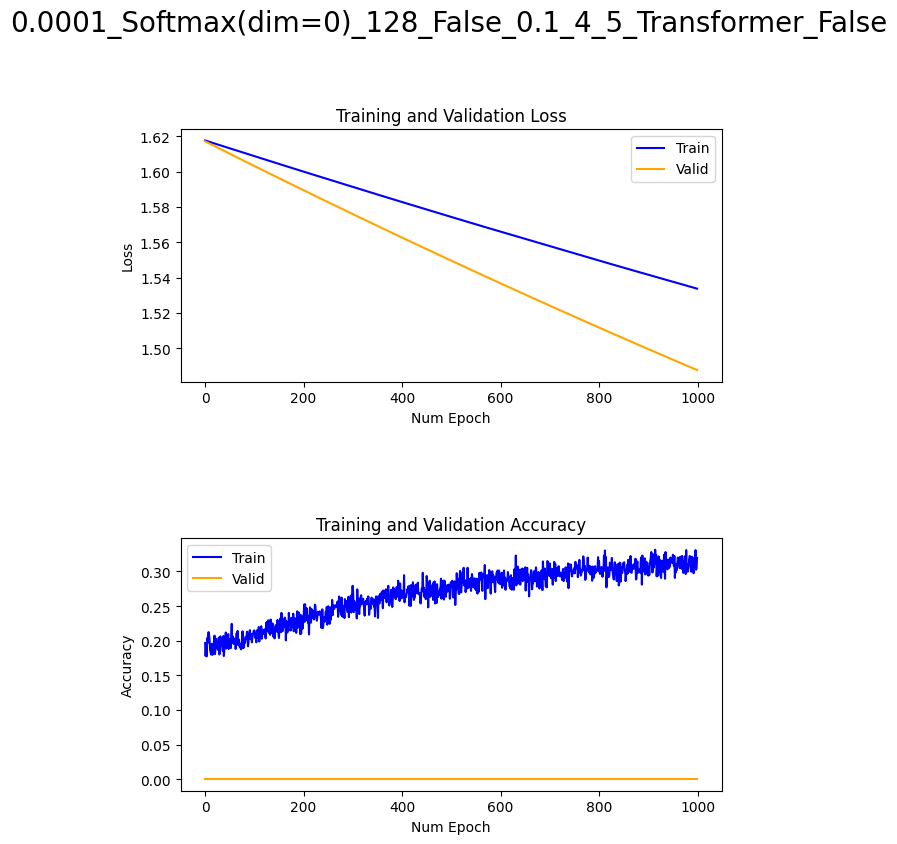

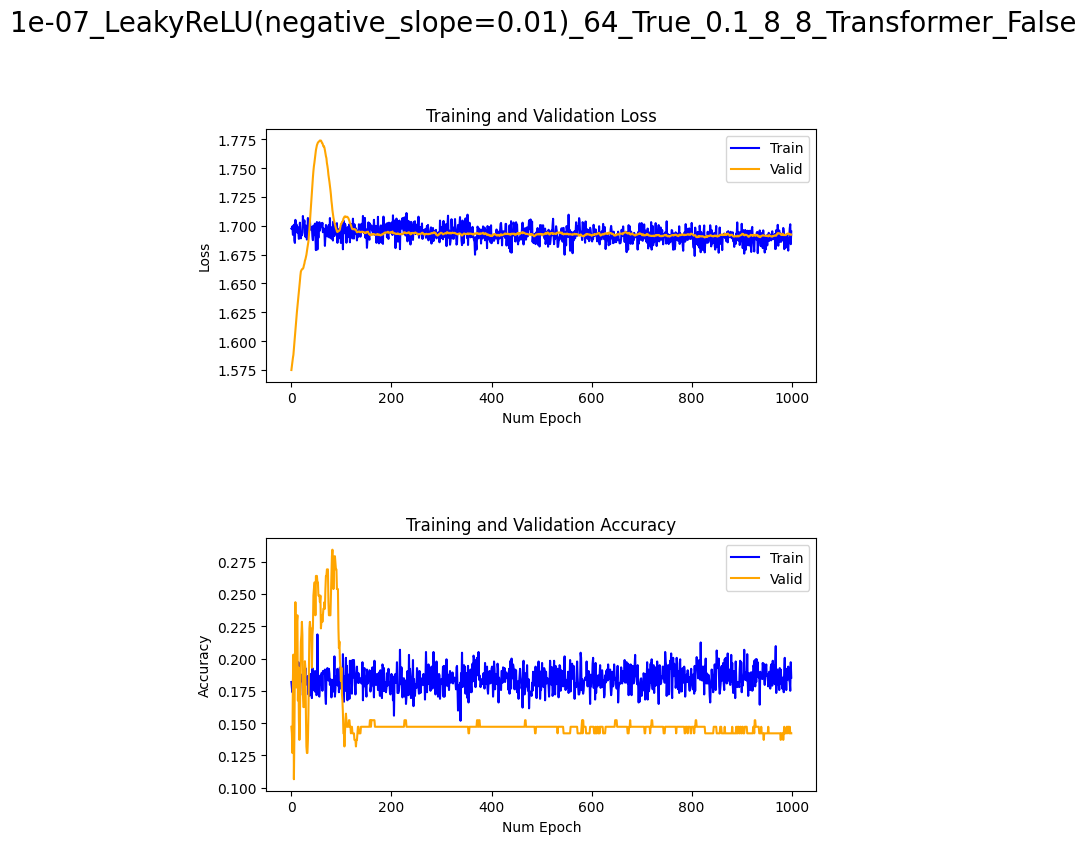

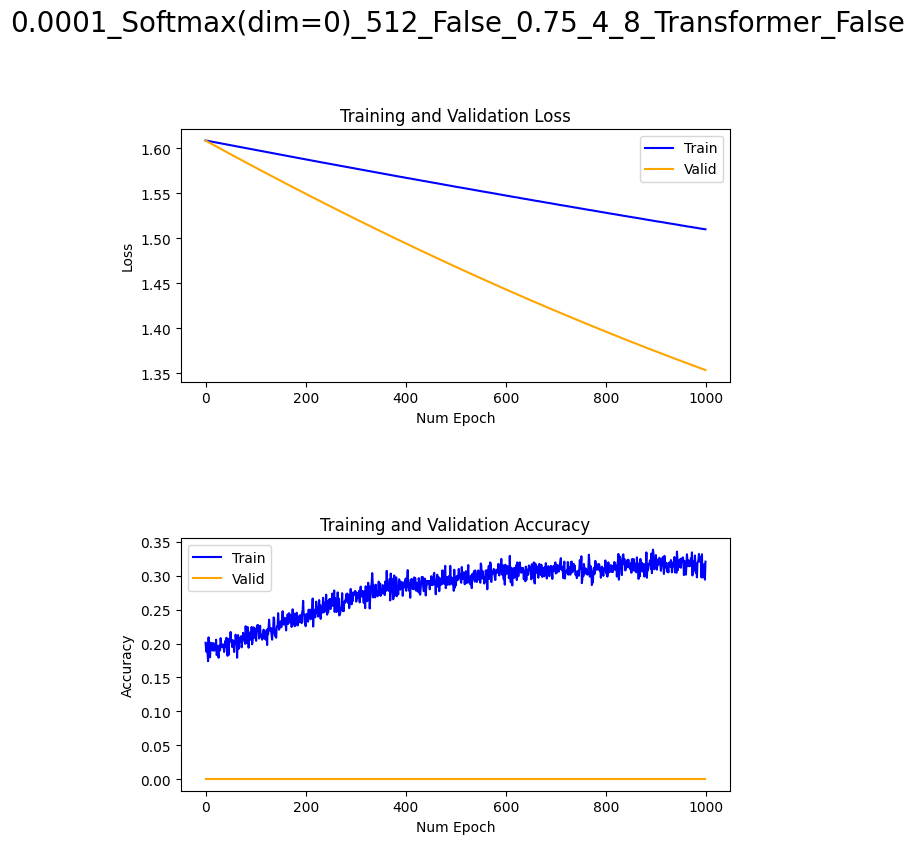

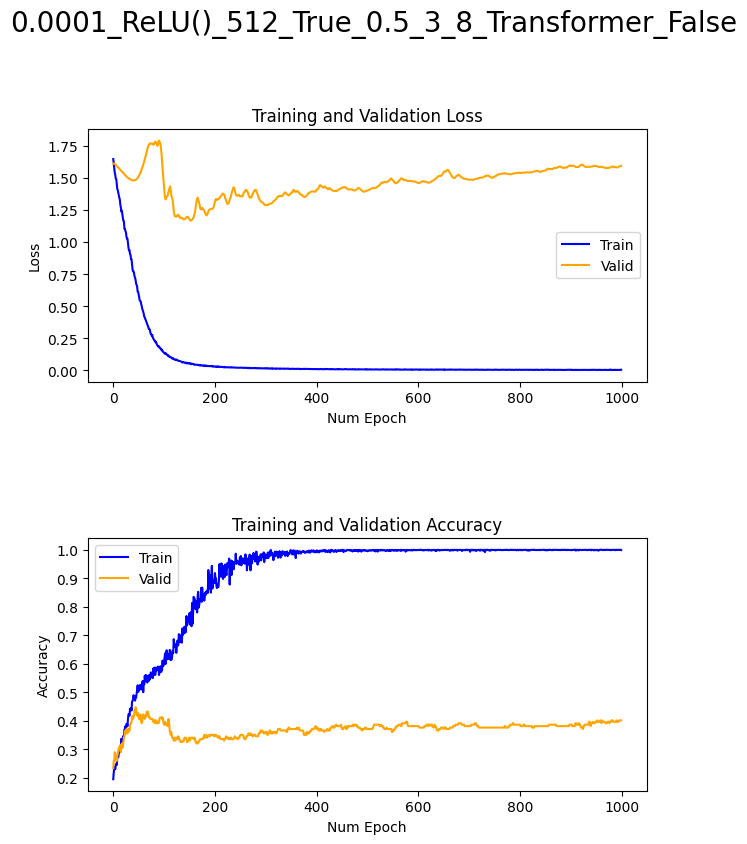

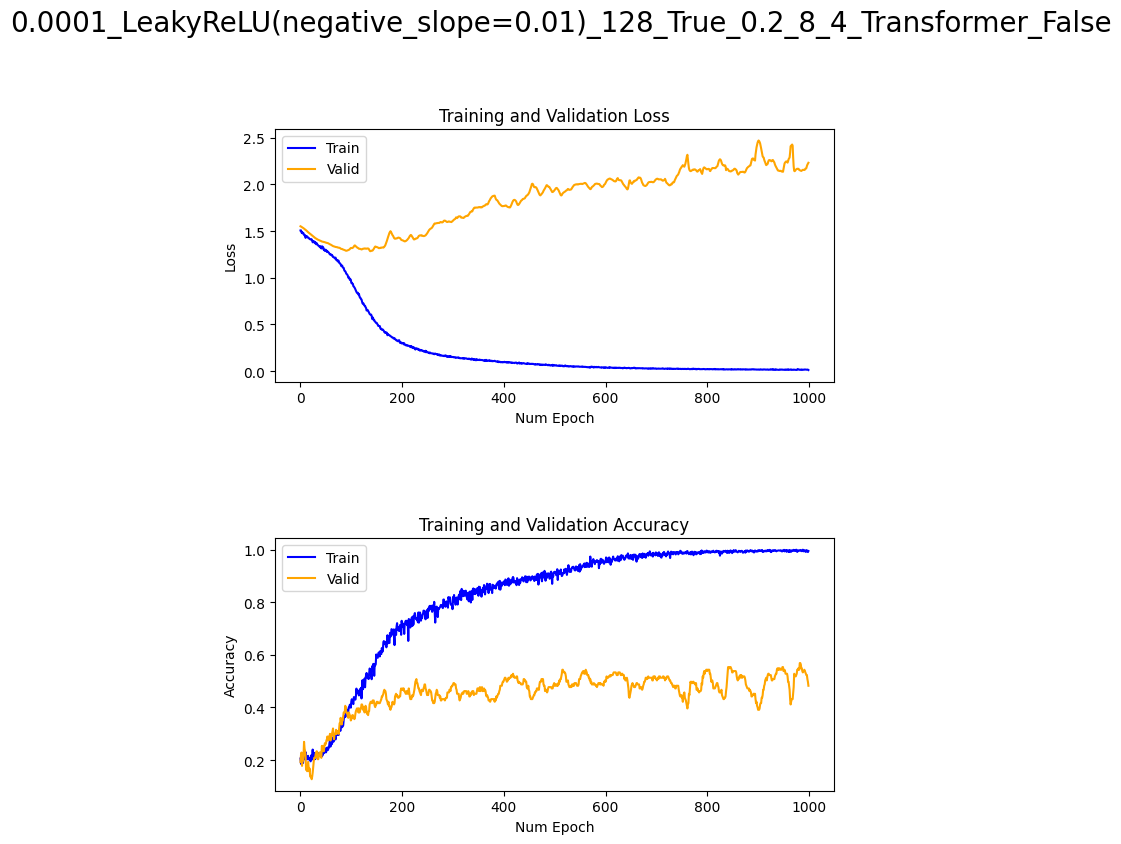

In [234]:
best_transformer_model = random_grid_search(
    architecture_type='Transformer', 
    lr_list=lr_list, 
    activation_function_list=activation_function_list, 
    neuron_num_list=neuron_num_list, 
    batch_norm_list=batch_norm_list, 
    dropout_rate_list=dropout_rate_list, 
    num_epochs=num_epochs, 
    early_stop_num=early_stop_num, 
    num_cnn_layers=num_linear_layers_list, 
    num_linear_layers=num_cnn_layers_list,
    num_combos=20, 
    seed_value=16)

In [235]:
transformer_model = TransformerEncoder(heads=8, num_linear_layers=5)

C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [236]:
best_cnn_model = random_grid_search(
    architecture_type='CNN', 
    lr_list=lr_list, 
    activation_function_list=activation_function_list, 
    neuron_num_list=neuron_num_list, 
    batch_norm_list=batch_norm_list, 
    dropout_rate_list=dropout_rate_list, 
    pretrained_embeddings=True,
    num_epochs=num_epochs, 
    early_stop_num=early_stop_num, 
    num_cnn_layers=num_linear_layers_list, 
    num_linear_layers=num_cnn_layers_list,
    num_combos=20, 
    seed_value=16)

Network Name: 1e-06_LeakyReLU(negative_slope=0.01)_128_True_0.75_8_5_CNN_True Trainable Parameters: 969253
Epoch: 0 Best Valid Loss: 1.6269316673278809 Current Valid loss: 1.6269316673278809 Current Train loss: 1.8852912187576294 Stop Counter: 0
Epoch: 1 Best Valid Loss: 1.6265907287597656 Current Valid loss: 1.6265907287597656 Current Train loss: 1.875984787940979 Stop Counter: 0
Epoch: 2 Best Valid Loss: 1.6265907287597656 Current Valid loss: 1.6278983354568481 Current Train loss: 1.8633594512939453 Stop Counter: 1
Epoch: 3 Best Valid Loss: 1.6265907287597656 Current Valid loss: 1.6292126178741455 Current Train loss: 1.9089237451553345 Stop Counter: 2
Epoch: 4 Best Valid Loss: 1.6265907287597656 Current Valid loss: 1.6290557384490967 Current Train loss: 1.861257553100586 Stop Counter: 3
Epoch: 5 Best Valid Loss: 1.6265907287597656 Current Valid loss: 1.628764033317566 Current Train loss: 1.8697688579559326 Stop Counter: 4
Epoch: 6 Best Valid Loss: 1.6265907287597656 Current Valid los

KeyboardInterrupt: 

In [ ]:
best_model = CNN(cnn_num_classes=5, activation_function=nn.LeakyReLU(), num_neurons=256, num_linear_layers=3, num_cnn_layers=3, batch_norm=False, dropout_rate=.2)
best_model.to('cpu')
best_model.load_state_dict(torch.load(r'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\model_weights\0.0001_LeakyReLU(negative_slope=0.01)_256_False_0.2_3_3_1', weights_only=True))

In [ ]:
# twitter_roberta test
t_roberta = TWITTERROBERTA()
t_roberta.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(t_roberta.parameters(), lr=.0001)
epoch_train_loss_list, epoch_valid_loss_list, epoch_train_accuracy_list, epoch_valid_accuracy_list = train_twitter_roberta(t_roberta, loss, optimizer, 10, 'ROBERTA TEST')
plot_loss_and_accuracy(epoch_train_loss_list, epoch_valid_loss_list, epoch_train_accuracy_list, epoch_valid_accuracy_list, title='ROBERTA TEST')

In [ ]:
best_model = TWITTERROBERTA()
best_model.to('cpu')
best_model.load_state_dict(torch.load(r'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\model_weights\ROBERTA TEST', weights_only=True))

## Predictions

In [ ]:
encoded_test = tokenizer.texts_to_sequences(test.text)

# pad sequences
test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
test = torch.tensor(test, dtype=torch.int).to('cpu')

In [ ]:
best_model.eval()
with torch.no_grad():
    outputs = best_model(torch.tensor(test))

In [ ]:
softmax_outputs = torch.nn.functional.one_hot(torch.argmax(nn.Softmax(dim=0)(outputs), dim=1)).to(torch.float)
softmax_outputs

In [ ]:
predictions = pd.from_dummies(pd.DataFrame(softmax_outputs.numpy()))

In [ ]:
predictions.columns = ['sentiment']

In [ ]:
predictions['id'] = predictions.index

In [ ]:
predictions = predictions[['id', 'sentiment']]
predictions.id = [x + 1 for x in predictions.id]

In [ ]:
predictions.reset_index(drop=True, inplace=True)
predictions.to_csv(r'C:\Users\connor\PycharmProjects\portfolio\predictions.csv')